# OOD enablement with finetuned resnet18 model demo

This demo will be using a pytorch resnet18 model finetuned on the hymenoptera dataset, a subset of ImageNet, as found in this official pytorch tutorial: 
[script](https://github.com/pytorch/tutorials/blob/main/beginner_source/transfer_learning_tutorial.py) 
and [documentation](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) from Pytorch. 

For this demo, the pretrained/finetuned model, as well as a subset of the indistrubtion dataset for OOD enablement can be downloaded from a public COS storage url: 

model: https://public-test-rhods.s3.us-east.cloud-object-storage.appdomain.cloud/model_ft_cpu_jit.pth

indistribution-data: https://public-test-rhods.s3.us-east.cloud-object-storage.appdomain.cloud/hymenoptera_data.zip

# Import required libraries

In [15]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader
from tensorflow.keras.utils import get_file

import json
import os
import sys
ood_path = os.path.abspath('../')
if ood_path not in sys.path:
    sys.path.append(ood_path)
    
from ood_enabler.ood_enabler import OODEnabler
from ood_enabler.storage.model_store import ModelStore
from ood_enabler.model_wrapper.pytorch import PytorchWrapper
from ood_enabler.data.pytorch_image_data_handler import PytorchImageDataHandler
from ood_enabler.storage.local_storage import FileSystemStorage
from ood_enabler.util.constants import SavedModelFormat

import warnings
warnings.filterwarnings('ignore')

In [2]:
def show_images(inputs, scores):
    w = 10
    h = 10
    fig = plt.figure(figsize=(20, 20))

    columns = 5
    rows = 1
    for i in range(1, columns*rows +1):
        img = inputs[i - 1].T
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.xlabel("Model Certainty Score: {0:.2f}".format(float(scores[i-1])))
    plt.show()
    


# Define metadata for the model that will be used

In [3]:
model_metadata = {'type': 'pytorch', 'arch': 'resnet18'}

# Download pretrained/finetuned resnet18 model and load from local storage

In [4]:
model_url = "https://public-test-rhods.s3.us-east.cloud-object-storage.appdomain.cloud/model_ft_cpu_jit.pth"

with TemporaryDirectory() as tmpdir:
    model_path = get_file(origin=model_url, extract=False, fname=os.path.join(tmpdir, 'pretrained_model.pth')) 
    model_store = ModelStore.from_filesystem()
    model = model_store.load(model_metadata, model_path)
    

44840485/44840485 [==============================] - 22s 1us/step
Number of layers for model from path:52
returning base model  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


# Define metadata for the in-distribution dataset that will be used

In [5]:
ds_metadata = {'img_height': 224, 'img_width': 224, 'batch_size': 32, 'normalize': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

# Download in-distribution subset and load into data handler

In [6]:
data_url = 'https://public-test-rhods.s3.us-east.cloud-object-storage.appdomain.cloud/hymenoptera_data.zip'
data_path = get_file(origin=data_url, extract=False)

local_store = FileSystemStorage()
data_handler = PytorchImageDataHandler()
data_handler.load_dataset(local_store, data_path, '.', ds_metadata)

# Enable model with OOD layer

In [7]:
OODEnabler.ood_enable(model, data_handler)

adding OOD layer pytorch


Inference progress: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it]

set_threshold for given data handler:Parameter containing:
tensor([0.8423])


# Download in-distribution samples to test OOD enablement and scoring

In [8]:
id_sample_url = 'https://public-test-rhods.s3.us-east.cloud-object-storage.appdomain.cloud/hymenoptera2.json'

with TemporaryDirectory() as tmpdir:
    id_sample = get_file(origin=id_sample_url, extract=False, fname=os.path.join(tmpdir, 'id_sample.json'))
    with open(id_sample, 'r') as f: 
        data = json.load(f)


14842538/14842538 [==============================] - 16s 1us/step


# Run inference through OOD-enabled model and review results
### OOD scores in second tensor 

In [9]:
scores = model.model(torch.Tensor(data['inputs'][0]['data']))

# Review in-distribution samples to test OOD enablement and scoring


## The ood-enabled model returns scores in the range of 0-1. Images with a score of 1 indicate the model is certain about a data sample, i.e the data sample is similar to what the model was trained on (in-distribution). Anything below that reflects a model being less certain that the provided sample is similar to it's training set, i.e. out-of-distribution. 

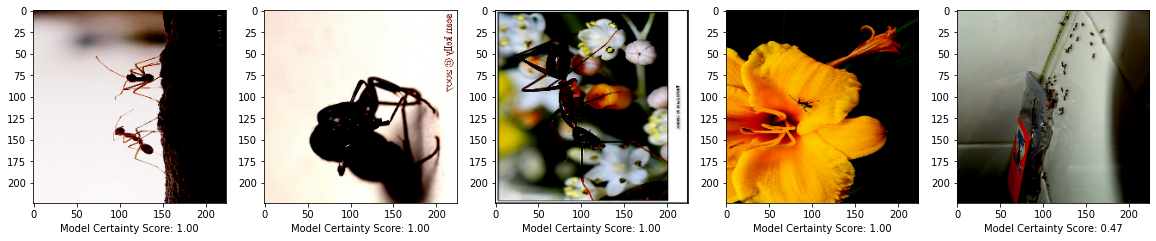

In [10]:
show_images(torch.Tensor(data['inputs'][0]['data']), list(scores[1]))

# Review out-of-distribution samples to test OOD enablement and scoring
## 3 sample urls provided 

In [11]:
ood_sample_url = 'https://public-test-rhods.s3.us-east.cloud-object-storage.appdomain.cloud/flowers2.json'
#ood_sample_url = 'https://public-test-rhods.s3.us-east.cloud-object-storage.appdomain.cloud/food101.json'
#ood_sample_url = 'https://public-test-rhods.s3.us-east.cloud-object-storage.appdomain.cloud/cifar10.json'

with TemporaryDirectory() as tmpdir:
    ood_sample = get_file(origin=ood_sample_url, extract=False, fname=os.path.join(tmpdir, 'ood_sample.json'))
    with open(ood_sample, 'r') as f: 
        data = json.load(f)

15568180/15568180 [==============================] - 20s 1us/step


# Run inference through OOD-enabled model and review results
### OOD scores in second tensor 

In [12]:
scores = model.model(torch.Tensor(data['inputs'][0]['data']))
scores

(tensor([[-2.3709,  0.2040],
         [-0.6459, -0.1565],
         [-0.5547, -0.6601],
         [-1.1951, -0.4063],
         [-1.0604, -0.2548]], grad_fn=<AddmmBackward0>),
 tensor([[0.3293],
         [0.3817],
         [0.1034],
         [0.0000],
         [0.1360]]))

# Review OOD samples to test OOD enablement and scoring

## The ood-enabled model returns scores in the range of 0-1. Images with a score of 1 indicate the model is certain about a data sample, i.e the data sample is similar to what the model was trained on (in-distribution). Anything below that reflects a model being less certain that the provided sample is similar to it's training set, i.e. out-of-distribution. 

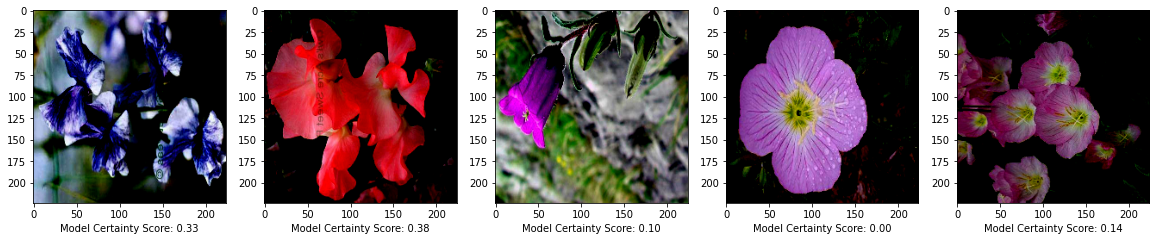

In [13]:
show_images(torch.Tensor(data['inputs'][0]['data']), list(scores[1]))

# Save OOD-enabled model

In [14]:
model_store.upload(model, '.')

'./ood_pytorch_20240304_16-47-38.pt'